# Setting up simulator

In [1]:
from typing import Any
import warnings

from rl_qoc.qua.quam_components.gate_macros import CZMacro

from qm import QuantumMachinesManager, SimulationConfig
from qm.qua import *
from qm_saas import QoPVersion, QmSaas
from rl_qoc.qua.quam_components import QuAM, MeasureMacro, ResetMacro, VirtualZMacro
from rl_qoc.qua.parameter_table import ParameterTable, Parameter as QuaParameter
from rl_qoc.qua.qm_backend import FluxTunableTransmonBackend
from quam.components.macro import PulseMacro
from quam.core.operation.operations_registry import OperationsRegistry
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector, QuantumRegister
import qiskit.pulse as qp
import matplotlib.pyplot as plt
from qm import generate_qua_script
import numpy as np

import warnings
import logging

# Silence DeprecationWarnings from qiskit.pulse
warnings.filterwarnings("ignore", category=DeprecationWarning, module=r"qiskit\.pulse")
warnings.simplefilter("ignore", category=DeprecationWarning)

opx_plus = False
opx_plus_str = "_opx_plus" if opx_plus else ""
machine = QuAM.load(
    f"/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/pulse_level/qua/quam_state{opx_plus_str}"
)
backend = FluxTunableTransmonBackend(machine)

2025-04-28 20:22:48,061 - qm - INFO     - Starting session: 2e45d304-d6b6-4b98-a4bd-92dd853c2387
2025-04-28 20:22:48 INFO Starting session: 2e45d304-d6b6-4b98-a4bd-92dd853c2387


In [2]:
q1 = machine.active_qubits[0]
q2 = machine.active_qubits[1]

In [17]:
for qubit in machine.active_qubits:
    qubit.macros["x"] = PulseMacro(pulse="x180")
    qubit.macros["rz"] = VirtualZMacro()
    qubit.macros["sx"] = PulseMacro(pulse="x90")
    qubit.macros["measure"] = MeasureMacro(pulse="readout")
    qubit.macros["reset"] = ResetMacro(pi_pulse="x180", readout_pulse="readout")

for qubit_pair in machine.active_qubit_pairs:
    qubit_pair.macros["cz"] = CZMacro(
        flux_pulse_control=qubit_pair.qubit_control.get_pulse(
            "flux_pulse"
        ).get_reference(),
        coupler_flux_pulse=qubit_pair.coupler.operations["cz"].get_reference(),
    )

In [19]:
machine.save(
    "/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/pulse_level/qua/quam_state"
)

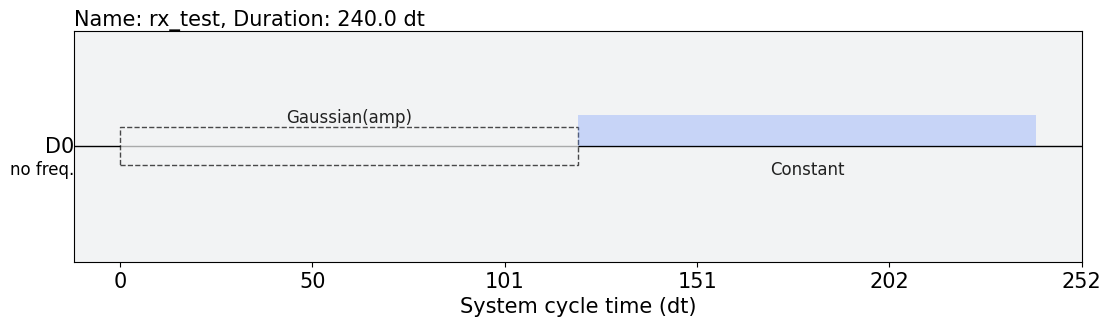

In [3]:
amp = Parameter("amp")
amp2 = Parameter("amp2")
phase = Parameter("phase")
with qp.build(name="rx_test") as sched:
    qp.set_frequency(0, qp.DriveChannel(0))
    qp.play(
        qp.Gaussian(duration=120, amp=amp, sigma=40, angle=0.0),
        qp.DriveChannel(0),
    )
    qp.play(qp.Constant(duration=120, amp=0.1), qp.DriveChannel(0))

sched.draw()

In [64]:
sched.parameters

{Parameter(amp)}

In [66]:
print(backend.target)

Target: Transmon based QuAM
Number of qubits: 5
Instructions:
	x
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	rz
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	sx
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	measure
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	reset
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	cz
		(0, 1)
		(1, 2)
		(2, 3)
		(3, 4)
	switch_case
	for_loop
	if_else
	while_loop



In [70]:
backend.add_pulse_operations(sched, name="qiskit")

In [71]:
backend.machine.qubits["q1"].resonator.operations.to_dict()

{'readout': {'length': 1440,
  'amplitude': 0.12875395041751653,
  'threshold': -1.628262415766392e-05,
  'rus_exit_threshold': -0.00014833485972262327,
  'integration_weights_angle': -1.8448264092890287,
  '__class__': 'quam.components.pulses.SquareReadoutPulse'},
 'const': {'length': 100,
  'amplitude': 0.125,
  '__class__': 'quam.components.pulses.SquarePulse'}}

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


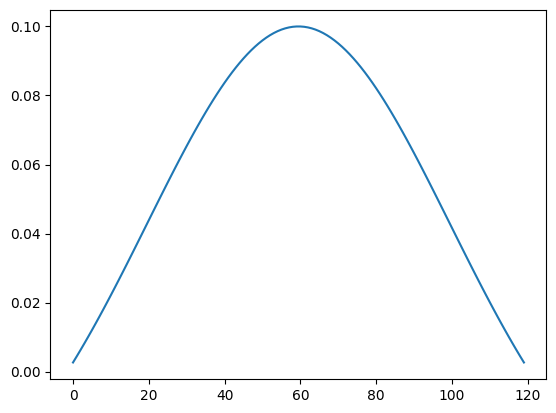

In [72]:
plt.plot(backend.machine.qubits["q1"].xy.operations["qiskit_0"].calculate_waveform())

In [24]:
# These should be changed to your credentials.
from pathlib import Path
import json

path = Path.home() / "qm_saas_config.json"
with open(path, "r") as f:
    config = json.load(f)
email = config["email"]
password = config["password"]
# Initialize QOP simulator client
client = QmSaas(email=email, password=password, host="qm-saas.dev.quantum-machines.co")

# Choose your QOP version (QOP2.x.y or QOP3.x.y)
version = QoPVersion.latest
param_table = ParameterTable.from_qiskit(sched)
client.close_all()

NameError: name 'sched' is not defined

In [15]:
machine.active_qubit_pairs
seed = 30499
mu = 0.4
sigma = 0.5

In [16]:
def get_gaussian_sampling_input():
    """
    Get the input for the gaussian sampling function
    """
    n_lookup = 512

    cos_array = declare(
        fixed,
        value=[(np.cos(2 * np.pi * x / n_lookup).tolist()) for x in range(n_lookup)],
    )
    ln_array = declare(
        fixed,
        value=[
            (np.sqrt(-2 * np.log(x / (n_lookup + 1))).tolist())
            for x in range(1, n_lookup + 1)
        ],
    )
    return (
        n_lookup,
        cos_array,
        ln_array,
    )

In [17]:
print(param_table)

ParameterTable(Parameter(name=amp, value=0.0, type=<class 'qm.qua._expressions.fixed'>, length=0, input_type=None, direction=OUTGOING, units=), )


In [18]:
backend.schedule_to_qua_macro(sched, param_table)

<function rl_qoc.qua.qm_backend.QMBackend.schedule_to_qua_macro.<locals>.qua_macro(amp)>

In [19]:
# Define a QUA program
with program() as prog:
    param_table.declare_variables()

    with strict_timing_():
        backend.schedule_to_qua_macro(sched, param_table)(**param_table.variables_dict)


# Open quantum machine with the provided configuration and simulate the QUA program

In [20]:
config = machine.generate_config()
print(generate_qua_script(prog))


# Single QUA script generated at 2025-04-24 21:54:37.259654
# QUA library version: 1.2.2rc2+dgx1


from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    v1 = declare(fixed, value=0.0)
    with strict_timing_():
        assign(v1, v1)
        update_frequency("q1.xy", 0, "Hz", False)
        play("qiskit_0"*amp((10.0*v1)), "q1.xy")
        play("qiskit_1", "q1.xy")

config = None

loaded_config = None




In [24]:
client.close_all()
config = machine.generate_config()
instance = client.simulator(version=version)
instance.spawn()
# Initialize QuantumMachinesManager with the simulation instance details
qmm = QuantumMachinesManager(
    host=instance.host,
    port=instance.port,
    connection_headers=instance.default_connection_headers,
)
qm = qmm.open_qm(config)
job = qm.simulate(prog, SimulationConfig(int(2000), include_analog_waveforms=True))

# Retrieve and handle simulated samples
samples = job.get_simulated_samples()
results = job.result_handles
results.wait_for_all_values()
results

2025-04-24 14:50:49,841 - qm - INFO     - Performing health check
2025-04-24 14:50:49 INFO Performing health check
2025-04-24 14:50:50,596 - qm - INFO     - Cluster healthcheck completed successfully.
2025-04-24 14:50:50 INFO Cluster healthcheck completed successfully.


/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qm/program/_qua_config_schema.py:1956: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


2025-04-24 14:50:52,707 - qm - INFO     - Simulating program.
2025-04-24 14:50:52 INFO Simulating program.


In [42]:
waveform_report = job.get_simulated_waveform_report()

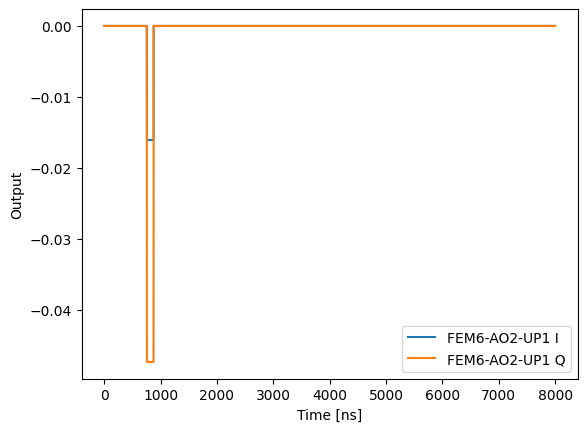

In [25]:
job.get_simulated_samples().con1.plot()

In [22]:
import matplotlib.pyplot as plt
import numpy as np

samples.con1.analog

{'6-2-1': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
 '6-2-2': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
 '6-3-1': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
 '6-3-2': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}

In [23]:
config

{'version': 1,
 'controllers': {'con1': {'fems': {2: {'type': 'LF',
     'analog_outputs': {1: {'delay': 172,
       'shareable': False,
       'sampling_rate': 1000000000.0,
       'upsampling_mode': 'pulse',
       'output_mode': 'amplified',
       'offset': 0.0}}},
    1: {'type': 'LF',
     'analog_outputs': {1: {'delay': 172,
       'shareable': False,
       'sampling_rate': 1000000000.0,
       'upsampling_mode': 'pulse',
       'output_mode': 'amplified',
       'offset': 0.0},
      2: {'delay': 172,
       'shareable': False,
       'sampling_rate': 1000000000.0,
       'upsampling_mode': 'pulse',
       'output_mode': 'amplified',
       'offset': 0.0},
      3: {'delay': 172,
       'shareable': False,
       'sampling_rate': 1000000000.0,
       'upsampling_mode': 'pulse',
       'output_mode': 'amplified',
       'offset': 0.0},
      4: {'delay': 172,
       'shareable': False,
       'sampling_rate': 1000000000.0,
       'upsampling_mode': 'pulse',
       'output_mode'

In [24]:
instance.close()

# OpenQASM3 to QUA

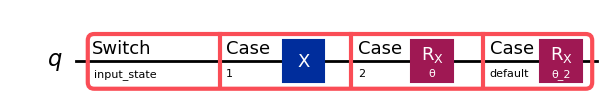

In [17]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, Gate, ParameterVector
from qiskit.qasm3 import Exporter, loads
from qiskit.circuit.classical.types import Uint
from qiskit import transpile

qc = QuantumCircuit(1)
theta = Parameter("θ")
theta2 = Parameter("θ_2")
theta3 = ParameterVector("θ_3", 2)
n = Parameter("n")
var = qc.add_input("input_state", Uint(8))
gate = Gate("my_gate", 1, [theta3[0]])
# with qc.for_loop([1, 3, 5]):
#     qc.x(0)
#     qc.rx(theta3[1]*n, 0)
#     qc.append(gate, [0])

with qc.switch(var) as case:
    with case(1):
        qc.x(0)
    with case(2):
        qc.rx(theta, 0)
    with case(case.DEFAULT):
        qc.rx(theta2, 0)
qc.draw("mpl")

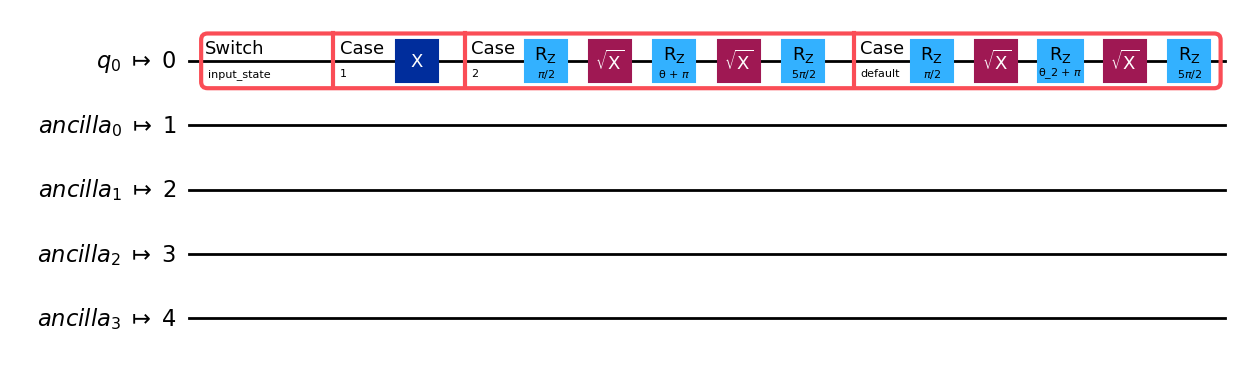

In [18]:
qc = transpile(qc, backend)
qc.draw("mpl")

In [19]:
# Convert Qiskit circuit to OpenQASM3
exporter = Exporter(
    includes=(),
    basis_gates=("my_gate", "rx", "x", "rz", "sx"),
    disable_constants=True,
)
qasm3 = exporter.dumps(qc)
print(qasm3)

OPENQASM 3.0;
input float[64] θ;
input float[64] θ_2;
input uint[8] input_state;
int switch_dummy;
switch_dummy = input_state;
switch (switch_dummy) {
  case 1 {
    x $0;
  }
  case 2 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(θ + 3.14159265358979) $0;
    sx $0;
    rz(7.853981633974483) $0;
  }
  default {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(θ_2 + 3.14159265358979) $0;
    sx $0;
    rz(7.853981633974483) $0;
  }
}



In [20]:
from oqc import HardwareConfig, Compiler, QubitsMapping, OperationIdentifier

yo2 = OperationIdentifier("my_gate", 1, (0,))
rx2 = OperationIdentifier("rx", 1, (0,))
x2 = OperationIdentifier("x", 0, (0,))
rz = OperationIdentifier("rz", 1, (0,))
sx = OperationIdentifier("sx", 0, (0,))

In [21]:
hardware_config = HardwareConfig(
    {
        yo2: lambda x: play("my_gate", "q1"),
        rx2: lambda theta: play("rx", "q1"),
        x2: lambda: play("x", "q1"),
        rz: lambda angle: frame_rotation(angle, "q1"),
        sx: lambda: play("sx", "q1"),
    },
    {0: ["xy"]},
)

In [22]:
compiler = Compiler(hardware_config)

In [23]:
result = compiler.compile(qasm3)

In [24]:
from qm import generate_qua_script

print(generate_qua_script(result.result_program.dsl_program))


# Single QUA script generated at 2025-04-28 17:57:18.092756
# QUA library version: 1.2.2rc2+dgx1


from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    input_stream_θ = declare_input_stream(fixed, 'θ', value=0.0)
    input_stream_θ_2 = declare_input_stream(fixed, 'θ_2', value=0.0)
    input_stream_input_state = declare_input_stream(int, 'input_state', value=0)
    v1 = declare(int, value=0)
    advance_input_stream(input_stream_θ)
    advance_input_stream(input_stream_θ_2)
    advance_input_stream(input_stream_input_state)
    assign(v1, input_stream_input_state)
    with if_((v1==1)):
        play("x", "q1")
    with elif_((v1==2)):
        frame_rotation_2pi(0.25, "q1")
        play("sx", "q1")
        frame_rotation_2pi(((input_stream_θ+3.14159265358979)*0.15915494309189535), "q1")
        play("sx", "q1")
        frame_rotation_2pi(1.25, "q1")
    with else_():
        frame_rotation_2pi(0.25, "q1")
        play("sx", "q1")
        frame_rotatio

In [10]:
from rl_qoc.rewards.real_time import get_real_time_reward_circuit
from rl_qoc import (
    QEnvConfig,
    QiskitConfig,
    ExecutionConfig,
    BenchmarkConfig,
    GateTargetConfig,
)
from rl_qoc.helpers.pulse_utils import custom_schedule
from rl_qoc.qua.quam_qiskit_pulse import FluxChannel
from gymnasium.spaces import Box


def apply_parameters(
    qc: QuantumCircuit, params: ParameterVector, qreg: QuantumRegister
):
    idx_0 = qreg.index(qreg[0])

    if len(qreg) > 1:
        idx_1 = qreg.index(qreg[1])
        with qp.build(backend) as sched:
            qp.play(qp.Constant(duration=120, amp=0.1), backend.flux_channel(idx_0))
            qp.play(
                qp.Constant(duration=120, amp=params[0]),
                backend.control_channel((idx_0, idx_1))[0],
            )
        qc.add_calibration(
            "rzz",
            [0, 1],
            sched,
            params.params if isinstance(params, ParameterVector) else params,
        )
        qc.rzz(params[0], qreg[0], qreg[1])
    else:
        with qp.build(backend) as sched:
            qp.play(
                qp.Drag(duration=120, amp=params[0], sigma=40, beta=0.2),
                backend.drive_channel(idx_0),
            )
        qc.add_calibration(
            "rx",
            [
                0,
            ],
            sched,
            params.params if isinstance(params, ParameterVector) else params,
        )
        qc.rx(params[0], qreg[0])


physical_qubits = [0, 1]
gate = "cz" if len(physical_qubits) > 1 else "x"
n_reps = 1
config = QEnvConfig(
    target=GateTargetConfig(physical_qubits, gate),
    backend_config=QiskitConfig(
        backend=backend,
        parametrized_circuit=apply_parameters,
    ),
    execution_config=ExecutionConfig(
        batch_size=1,
        n_shots=100,
        n_reps=n_reps,
        control_flow_enabled=True,
    ),
    reward="channel",
    action_space=Box(low=-1, high=1, shape=(1,), dtype=np.float32),
)

In [11]:
from rl_qoc.qua.qm_config import QMConfig

qm_config_args = {
    "input_type": "INPUT_STREAM",
    "num_updates": 500,
}
config.backend_config = QMConfig(**config.backend_config.as_dict(), **qm_config_args)

In [12]:
config.backend_config

QMConfig(parametrized_circuit=<function apply_parameters at 0x371876520>, backend=<rl_qoc.qua.qm_backend.FluxTunableTransmonBackend object at 0x36d9b8dd0>, parametrized_circuit_kwargs={}, skip_transpilation=False, pass_manager=None, instruction_durations=None, hardware_config=None, apply_macro=None, reset_type='active', input_type=<InputType.INPUT_STREAM: 'INPUT_STREAM'>, num_updates=500)

In [13]:
from rl_qoc.qua import QMEnvironment

q_env = QMEnvironment(config)

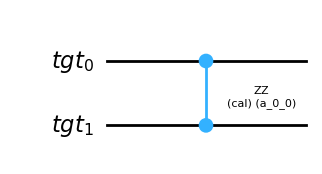

In [14]:
q_env.circuits[0].draw("mpl")

In [15]:
q_env.circuits[0].calibrations

{'rzz': {((0, 1),
   (Parameter(a_0_0),)): ScheduleBlock(Play(Constant(duration=120, amp=0.1, angle=0.0), FluxChannel(0)), Play(Constant(duration=120, amp=a_0_0, angle=0.0), ControlChannel(0)), name="block1", transform=AlignLeft())}}

In [16]:
circuit = get_real_time_reward_circuit(
    q_env.circuits, q_env.target, q_env.config, reward_method="channel"
)

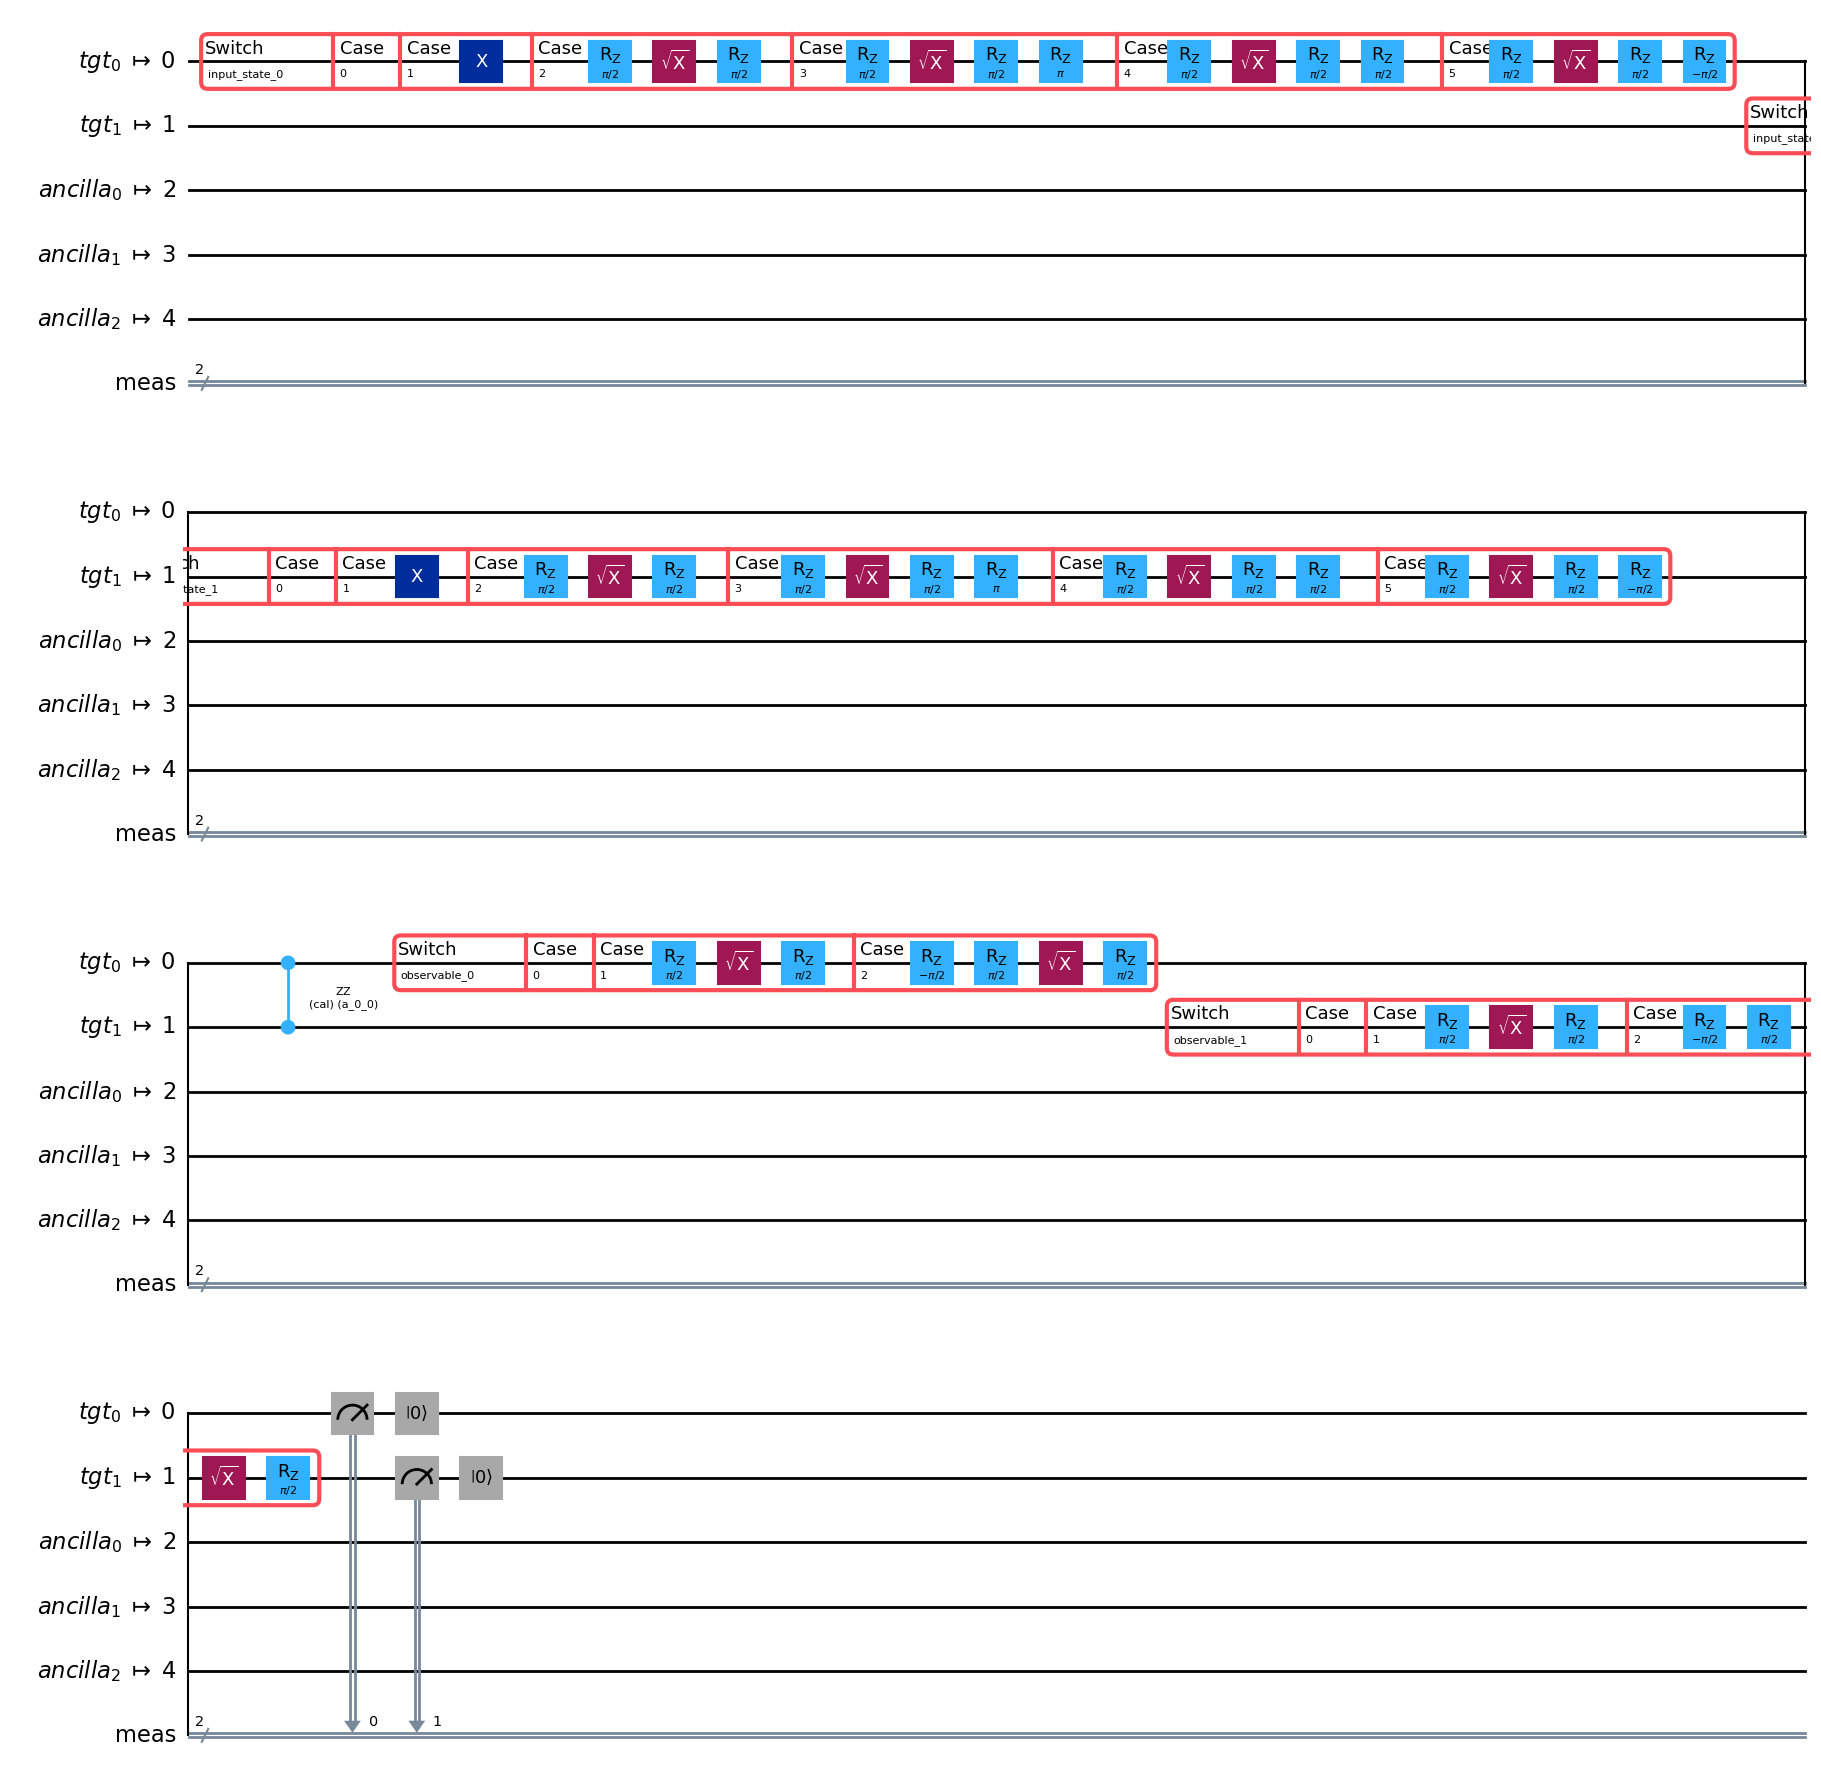

In [17]:
circuit.draw("mpl")

In [18]:
circuit.cregs

[ClassicalRegister(2, 'meas')]

In [19]:
circuit.find_bit(circuit.clbits[0])

BitLocations(index=0, registers=[(ClassicalRegister(2, 'meas'), 0)])

In [20]:
circuit.calibrations

{'rzz': {((0, 1),
   (Parameter(a_0_0),)): ScheduleBlock(Play(Constant(duration=120, amp=0.1, angle=0.0), FluxChannel(0)), Play(Constant(duration=120, amp=a_0_0, angle=0.0), ControlChannel(0)), name="block1", transform=AlignLeft())}}

In [21]:
from qiskit.qasm3 import Exporter

backend.update_calibrations(circuit)
basis_gates = backend.operation_names
print(basis_gates)
# Remove control flow operations, measure and reset from basis gates
basis_gates = [gate for gate in basis_gates if gate not in ["measure", "reset"]]
print(basis_gates)
exporter = Exporter(includes=(), basis_gates=basis_gates, disable_constants=True)

qasm3 = exporter.dumps(circuit)
print(qasm3)

['x', 'rz', 'sx', 'measure', 'reset', 'cz', 'switch_case', 'for_loop', 'if_else', 'while_loop']
['x', 'rz', 'sx', 'cz', 'switch_case', 'for_loop', 'if_else', 'while_loop']
OPENQASM 3.0;
input float[64] a_0_0;
input uint[4] observable_1;
input uint[4] input_state_0;
input uint[4] observable_0;
input uint[4] input_state_1;
gate cx c, t {
  ctrl @ U(pi, 0, pi) c, t;
}
gate rzz(p0) _gate_q_0, _gate_q_1 {
  cx _gate_q_0, _gate_q_1;
  rz(p0) _gate_q_1;
  cx _gate_q_0, _gate_q_1;
}
bit[2] meas;
int switch_dummy;
int switch_dummy_0;
int switch_dummy_1;
int switch_dummy_2;
switch_dummy = input_state_0;
switch (switch_dummy) {
  case 0 {
  }
  case 1 {
    x $0;
  }
  case 2 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(1.5707963267948966) $0;
  }
  case 3 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(1.5707963267948966) $0;
    rz(3.141592653589793) $0;
  }
  case 4 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(1.5707963267948966) $0;
    rz(1.5707963267948966) $0;
  }
  case 5 {

In [55]:
q_env.backend._operation_mapping_QUA

['x', 'rz', 'sx', 'measure', 'reset', 'cz', 'switch_case', 'for_loop', 'if_else', 'while_loop']
['x', 'rz', 'sx', 'cz', 'switch_case', 'for_loop', 'if_else', 'while_loop']
OPENQASM 3.0;
input float[64] a_0_0;
input uint[4] observable_0;
input uint[4] input_state_0;
input uint[4] observable_1;
input uint[4] input_state_1;
gate cx c, t {
  ctrl @ U(pi, 0, pi) c, t;
}
gate rzz(p0) _gate_q_0, _gate_q_1 {
  cx _gate_q_0, _gate_q_1;
  rz(p0) _gate_q_1;
  cx _gate_q_0, _gate_q_1;
}
bit[2] meas;
int switch_dummy;
int switch_dummy_0;
int switch_dummy_1;
int switch_dummy_2;
switch_dummy = input_state_0;
switch (switch_dummy) {
  case 0 {
  }
  case 1 {
    x $0;
  }
  case 2 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(1.5707963267948966) $0;
  }
  case 3 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(1.5707963267948966) $0;
    rz(3.141592653589793) $0;
  }
  case 4 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(1.5707963267948966) $0;
    rz(1.5707963267948966) $0;
  }
  case 5 {

In [13]:
from quam_builder.architecture.superconducting.qpu.flux_tunable_qpu import (
    FluxTunableQuam,
)

result = q_env.backend.quantum_circuit_to_qua(circuit).result_program

['x', 'rz', 'sx', 'measure', 'reset', 'cz', 'switch_case', 'for_loop', 'if_else', 'while_loop']
['x', 'rz', 'sx', 'cz', 'switch_case', 'for_loop', 'if_else', 'while_loop']
OPENQASM 3.0;
input float[64] a_0_0;
input uint[4] input_state_0;
input uint[4] input_state_1;
input uint[4] observable_0;
input uint[4] observable_1;
gate cx c, t {
  ctrl @ U(pi, 0, pi) c, t;
}
gate rzz(p0) _gate_q_0, _gate_q_1 {
  cx _gate_q_0, _gate_q_1;
  rz(p0) _gate_q_1;
  cx _gate_q_0, _gate_q_1;
}
bit[2] meas;
int switch_dummy;
int switch_dummy_0;
int switch_dummy_1;
int switch_dummy_2;
switch_dummy = input_state_0;
switch (switch_dummy) {
  case 0 {
  }
  case 1 {
    x $0;
  }
  case 2 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(1.5707963267948966) $0;
  }
  case 3 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(1.5707963267948966) $0;
    rz(3.141592653589793) $0;
  }
  case 4 {
    rz(1.5707963267948966) $0;
    sx $0;
    rz(1.5707963267948966) $0;
    rz(1.5707963267948966) $0;
  }
  case 5 {

In [57]:
result["meas"]

In [17]:
from qm import generate_qua_script

print(generate_qua_script(result.dsl_program))

In [18]:
param_table = ParameterTable.from_qiskit(
    circuit, filter_function=lambda x: "input" in x.name
)

In [23]:
print(generate_qua_script(q_env.rl_qoc_training_qua_prog()))


# Single QUA script generated at 2025-04-28 20:24:22.394321
# QUA library version: 1.2.2rc2+dgx1




    ####     SERIALIZATION VALIDATION ERROR     ####
    #
    #  for is not valid
    #
    # Trace:
    #   ['Traceback (most recent call last):\n', '  File "/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qm/serialization/generate_qua_script.py", line 100, in _generate_qua_script_pb\n    visitor.visit(proto_prog)\n', '  File "/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qm/serialization/qua_node_visitor.py", line 53, in visit\n    self.__visit(node)\n', '  File "/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qm/serialization/qua_node_visitor.py", line 59, in __visit\n    self._enter_visit_leave(node)\n', '  File "/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qm/serialization/qua_node_visitor.py", line 67, in _enter_visit_leave\n    self.__call_visit(type_fullname, node)\n', '  F

In [30]:
q_env.input_state_vars

ParameterTable(Parameter(name=input_state_0, value=0, type=<class 'int'>, length=0, input_type=INPUT_STREAM, direction=OUTGOING, units=), Parameter(name=input_state_1, value=0, type=<class 'int'>, length=0, input_type=INPUT_STREAM, direction=OUTGOING, units=), )

In [10]:
from rl_qoc.rewards import ChannelReward
import numpy as np

reward = ChannelReward()
reward_data = reward.get_reward_data(
    q_env.circuits[0], np.zeros((1, q_env.n_actions)), q_env.target, q_env.config
)

In [60]:
reward_data.fiducials_indices

In [64]:
reward_data.pubs[3].circuit.draw("mpl")

[((3, 0), [(1, 3)]),
 ((3, 1), [(1, 3)]),
 ((2, 1), [(1, 3)]),
 ((2, 0), [(1, 3)]),
 ((5, 1), [(2, 3)]),
 ((5, 0), [(2, 3)]),
 ((4, 0), [(2, 3)]),
 ((4, 1), [(2, 3)]),
 ((1, 0), [(3, 3)]),
 ((0, 0), [(3, 3)]),
 ((0, 1), [(3, 3)]),
 ((1, 1), [(3, 3)]),
 ((1, 2), [(3, 1)]),
 ((0, 2), [(3, 1)]),
 ((0, 3), [(3, 1)]),
 ((1, 3), [(3, 1)]),
 ((2, 3), [(2, 2)]),
 ((3, 3), [(2, 2)]),
 ((2, 2), [(2, 2)]),
 ((3, 2), [(2, 2)]),
 ((4, 2), [(1, 2)]),
 ((5, 2), [(1, 2)]),
 ((5, 3), [(1, 2)]),
 ((4, 3), [(1, 2)]),
 ((1, 4), [(3, 2)]),
 ((0, 4), [(3, 2)]),
 ((0, 5), [(3, 2)]),
 ((1, 5), [(3, 2)]),
 ((2, 5), [(2, 1)]),
 ((3, 4), [(2, 1)]),
 ((2, 4), [(2, 1)]),
 ((3, 5), [(2, 1)]),
 ((5, 5), [(1, 1)]),
 ((5, 4), [(1, 1)]),
 ((4, 5), [(1, 1)]),
 ((4, 4), [(1, 1)])]

In [42]:
param_table.get_parameter(0)

ChannelRewardData(pub=EstimatorPub(<(1,)>), input_circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3865147d0>, observables=SparsePauliOp(['X'],
              coeffs=[-13.+0.j]), shots=1300, n_reps=1, causal_cone_qubits_indices=[0], input_pauli=Pauli('X'), input_indices=(3,), observables_indices=[(1,)])

In [77]:
from qiskit.pulse.transforms import block_to_schedule

with qp.build(backend) as sched2:
    qp.call(sched)
    qp.acquire(100, qp.AcquireChannel(0), qp.MemorySlot(0))
    qp.measure_all()

block_to_schedule(sched2)

False

In [19]:
from qiskit_ibm_runtime.fake_provider.backends import FakeAthensV2

In [30]:
backend2 = FakeAthensV2()

backend2.target["measure"][(0,)].calibration.instructions

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_34461/1007896907.py:3: DeprecationWarning: The property ``qiskit.transpiler.target.InstructionProperties.calibration`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics. Note that once removed, ``qiskit.transpiler.target.InstructionProperties.calibration`` will have no alternative in Qiskit.
  backend2.target["measure"][(0,)].calibration.instructions


((0, Acquire(9776, AcquireChannel(0), MemorySlot(0), , , )),
 (0, Acquire(9776, AcquireChannel(1), MemorySlot(1), , , )),
 (0, Acquire(9776, AcquireChannel(2), MemorySlot(2), , , )),
 (0, Acquire(9776, AcquireChannel(3), MemorySlot(3), , , )),
 (0, Acquire(9776, AcquireChannel(4), MemorySlot(4), , , )),
 (0,
  Play(GaussianSquare(duration=9776, sigma=64, width=9520, amp=0.08, angle=-0.3129182953764417, name='gaussian_square_7ee7'), MeasureChannel(0), name='gaussian_square_7ee7')),
 (9776, Delay(3824, MeasureChannel(0))))

In [27]:
backend2.target["reset"]

{(0,): InstructionProperties(duration=3.431111111111111e-06, error=None, calibration=None),
 (1,): InstructionProperties(duration=3.431111111111111e-06, error=None, calibration=None),
 (2,): InstructionProperties(duration=3.431111111111111e-06, error=None, calibration=None),
 (3,): InstructionProperties(duration=3.431111111111111e-06, error=None, calibration=None),
 (4,): InstructionProperties(duration=3.431111111111111e-06, error=None, calibration=None)}

In [3]:
from rl_qoc.qua.quam_qiskit_pulse import FluxChannel

with qp.build(backend) as sched:
    print(qp.qubit_channels(2))
    qp.play(
        qp.Gaussian(duration=120, amp=0.1, sigma=40),
        FluxChannel(2),
    )

{MeasureChannel(2), AcquireChannel(2), DriveChannel(2)}


In [25]:
backend.channel_mapping[qp.ControlChannel(3)].name

'coupler_q4_q5'

In [45]:
backend.control_channel((1, 0))

ValueError: Control channel not found for qubit pair [1, 0] in the channel mapping